In [130]:
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [131]:
import importlib
import gp
importlib.reload(gp)


<module 'gp' from 'c:\\Users\\Yue\\userDoc\\7 code\\Python\\advml\\conditional-marginal-likelihood-sequence\\gp.py'>

# Dataset characteristics<br>
- instant: record index<br>
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month (1 to 12)
- hr : hour (0 to 23)
- holiday : whether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [3]:
import pandas as pd

df = pd.read_csv("hour.csv")
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


# Data Preprocess

In [4]:
reference_date = pd.Timestamp('2011-01-01')
df.iloc[:, 1] = (pd.to_datetime(df.iloc[:, 1]) - reference_date).dt.days
data = df.to_numpy(dtype=float)
data

array([[1.0000e+00, 0.0000e+00, 1.0000e+00, ..., 3.0000e+00, 1.3000e+01,
        1.6000e+01],
       [2.0000e+00, 0.0000e+00, 1.0000e+00, ..., 8.0000e+00, 3.2000e+01,
        4.0000e+01],
       [3.0000e+00, 0.0000e+00, 1.0000e+00, ..., 5.0000e+00, 2.7000e+01,
        3.2000e+01],
       ...,
       [1.7377e+04, 7.3000e+02, 1.0000e+00, ..., 7.0000e+00, 8.3000e+01,
        9.0000e+01],
       [1.7378e+04, 7.3000e+02, 1.0000e+00, ..., 1.3000e+01, 4.8000e+01,
        6.1000e+01],
       [1.7379e+04, 7.3000e+02, 1.0000e+00, ..., 1.2000e+01, 3.7000e+01,
        4.9000e+01]])

In [5]:
X_whole = data[:, 1:14] # the first column is index, not necessary
Y_whole = data[:, 16] # count of total rental bikes as label
X_whole 

array([[0.000e+00, 1.000e+00, 0.000e+00, ..., 2.879e-01, 8.100e-01,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.727e-01, 8.000e-01,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.727e-01, 8.000e-01,
        0.000e+00],
       ...,
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.576e-01, 6.000e-01,
        1.642e-01],
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.727e-01, 5.600e-01,
        1.343e-01],
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.727e-01, 6.500e-01,
        1.343e-01]])

In [6]:
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X-mean)/std, mean, std

def split_train_test(X_whole, Y_whole, num=1500, rate=0.7):
    # Shuffle data first
    indices = jax.random.permutation(grab_prng(), X_whole.shape[0])
    X_part = X_whole[indices]
    Y_part = Y_whole[indices]
    
    indices = jax.random.permutation(grab_prng(), num)
    X_shuffled = X_part[indices]
    Y_shuffled = Y_part[indices]
    
    # Standardize the shuffled data
    X, mean, std = standardize(X_shuffled)
    Y, mean, std = standardize(Y_shuffled)

    # Use the same indices for Y
    # Y = Y_shuffled
    
    # Compute the split index
    split_idx = int(num * rate)
    
    # Split indices into train and test
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Split data using the indices
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    
    return X_train, Y_train, X_test, Y_test


In [7]:
def split_sequence(X_train, Y_train, seq_len=8):
    n_samples = X_train.shape[0]
    indices = jax.random.permutation(grab_prng(), n_samples)
     # Shuffle the data
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]
    
    # Calculate the base size of each subset
    subset_size = n_samples // seq_len
    remainder = n_samples % seq_len
    
    # Initialize lists to hold the subsets
    X_seq = []
    Y_seq = []
    
    start_idx = 0
    for i in range(seq_len):
        # The first subset gets the remainder (extra) samples
        if i == 0:
            end_idx = start_idx + subset_size + remainder
        else:
            end_idx = start_idx + subset_size
        
        X_seq.append(X_train_shuffled[start_idx:end_idx])
        Y_seq.append(Y_train_shuffled[start_idx:end_idx])
        
        start_idx = end_idx
    return X_seq, Y_seq

In [8]:
X_train, Y_train, X_test, Y_test = split_train_test(X_whole, Y_whole, num=1500, rate=0.7)
X_con, Y_con = split_sequence(X_train, Y_train, seq_len=2)
X_seq, Y_seq = split_sequence(X_train, Y_train, seq_len=8)



Array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

Array([[ 1.39418953,  1.33510352,  0.98807114, ...,  1.02985878,
        -1.49421232, -0.43251876],
       [-0.08912232,  1.33510352, -1.01207287, ..., -1.10712155,
        -0.52383403,  0.54613803],
       [ 0.17235894, -1.3748495 ,  0.98807114, ..., -1.01837456,
        -1.03455945, -0.43251876],
       ...,
       [ 1.42746896,  1.33510352,  0.98807114, ..., -1.10712155,
         1.26370492,  0.05680963],
       [-1.05422586, -0.47153183, -1.01207287, ...,  1.02985878,
         0.14010901,  0.05680963],
       [ 1.2563176 ,  1.33510352,  0.98807114, ..., -0.1279661 ,
         0.24225409, -0.18744474]], dtype=float64)

# Hyperparameter initialization

Note that, in the below initialization, it is assumed that noise variance is the first component, signal variance the second, and length scale the third. Feel free to modify if using pytrees.

Further note: these are assumed constrained (strictly positive). You should map to unconstrained prior to running optimization, and map back to constrained when forming the GP posterior, and evaluating the predictive density for evaluation.

In [9]:
# def random_init_sqexp_hyperparams():
#     return np.array([jax.random.uniform(grab_prng(), minval=0.2, maxval=2),
#                      jax.random.uniform(grab_prng(), minval=0.2, maxval=2),
#                      X_train.shape[1]*jax.random.uniform(grab_prng(), minval=1, maxval=10)])
#

# Plotting code

In [10]:
def scatterplot(lml_lpd):
    plt.scatter(lml_lpd[:,0], lml_lpd[:,1])
    
    plt.xlabel('Log marginal likelihood')
    plt.ylabel('Negative log predictive density')
    plt.title('Is marginal likelihood a good indicator of generalization?')
    plt.legend()
#

# Experiment 1: Empirical Bayes for squared-exponential kernel

In [11]:
# n_trials = 20
# T = 200
# step_size = 5e-4

# gathered_trials = []
# hyperparams_inits = []
# for i in range(n_trials):
#    hyperparams_inits.append(random_init_sqexp_hyperparams())

# cov_func = sqexp_cov_function
# X_star = X_test
# for n in range(n_trials):
#    hyperparams_init = hyperparams_inits[n]
#    unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   
#    # sqexp_cov_function(X_train, X_train, unconstrained_hyperparams_init)
   
#    (unconstrained_hyperparams, lml) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
#    hyperparams = param_transform(unconstrained_hyperparams)
   
#    posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
#    (posterior_mean, posterior_var) = posterior_predictive(X_star)
#    neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

#    posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
#    (posterior_mean, posterior_var) = posterior_predictive(X_star)
#    neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])

#    print(np.array([neg_log_initial, neg_log_final, lml]))
#    gathered_trials.append(np.array([neg_log_initial, neg_log_final, lml]))
# #
# gathered_trials

In [12]:
# trials_array = np.array(gathered_trials)
# lml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
# scatterplot(lml_lpd)


# Dicsussion
1. Negative log probability was consistently improved over the hyperparameters used at initialization, across all runs.
2. According to the scatterplot above, we can see that as log marginal likelihood increases, negative log predicitive density on test set decreases at first, and increases later. Log marginal likelihood is a metric of our hyperparameters. The larger log marginal likelihood is, the better our hyperparameters are. But if they are better is determined by training set. Thus it's reasonable that "better" hyperparameters on training set don't always work better on test set. A large marginal likelihood may cause overfitting, although it works very well on training set. It's not a good indicator of generalization.

# Experiment 2 - feature importance using learned Mahalanobis distances

In [13]:
# use as your initial hyperparameters -> first two parameters are noise variance and signal variance,
# remaining parameters are length scale; feel free to modify if using pytrees
def random_init_sqexp_maha_hyperparams(X_train):
    var = jax.random.uniform(grab_prng(), shape=(2,), minval=0.2, maxval=2)
    length_scale = jax.random.uniform(grab_prng(), shape=(X_train.shape[1],), minval=1, maxval=10)
    return np.concatenate([var, length_scale])


In [14]:
# experiment settings
n_trials = 20
T = 200
step_size = 5e-4
cov_func = sqexp_mahalanobis_cov_function
X_star = X_test
hyperparams_inits = []
for i in range(n_trials):
   hyperparams_inits.append(random_init_sqexp_maha_hyperparams(X_train))


In [15]:
# optimize hyperparameters according lml
lml_trials = []

for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, lml) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, lml]))
   lml_trials.append(np.array([neg_log_initial, neg_log_final, lml]))
# #

[567.89243329 215.65414922 632.92670722]
[593.74975905 217.5088902  630.16971626]
[631.9587167  214.28324949 638.75254058]
[579.71656603 212.13452129 637.12743329]
[559.58732511 216.81365264 623.12234438]
[665.6606515  218.12799622 618.01994609]
[544.39419656 218.23923485 635.59022173]
[540.02665297 215.88691301 631.74126577]
[639.46409336 225.09409304 624.36601147]
[489.91515816 214.6305671  638.02101682]
[522.29669987 212.25303733 633.81943677]
[633.04966745 218.8229232  631.42988429]
[582.45373208 219.53324771 618.56336712]
[637.40621802 217.17466712 623.80507419]
[522.35905157 213.12527258 628.18267663]
[617.63687302 212.38127046 629.03279666]
[493.50981595 215.88102323 636.79957933]
[531.07252798 211.83676848 635.6028487 ]
[513.68557193 216.47361243 628.54519739]
[645.13629061 211.84442549 631.99620321]


C:\Users\Yue\AppData\Local\Temp\ipykernel_9632\1312685826.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


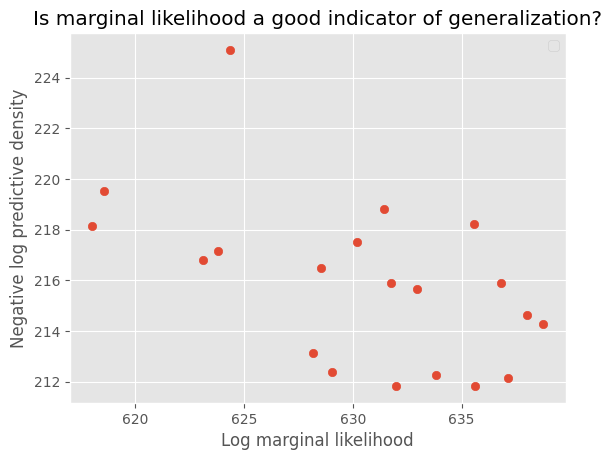

In [16]:
trials_array = np.array(lml_trials)
lml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(lml_lpd)

In [17]:
# optimize hyperparameters according lml
clml_trials = []

for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, clml) = clml_opt(cov_func, X_con, Y_con, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, clml]))
   clml_trials.append(np.array([neg_log_initial, neg_log_final, clml]))

[ 567.89243329  228.85383396 -102.32790417]
[ 593.74975905  210.97946248 -108.5461049 ]
[631.9587167  243.55871702 -91.11108752]
[579.71656603 235.25827558 -93.50752166]
[ 559.58732511  197.6342836  -128.32457121]
[ 665.6606515   183.95588604 -157.78174489]
[544.39419656 243.06412898 -92.92782123]
[ 540.02665297  205.74038386 -110.97775141]
[ 639.46409336  224.92168407 -118.61173251]
[489.91515816 239.22688534 -93.21776769]
[ 522.29669987  201.75943676 -108.22030068]
[ 633.04966745  233.03595218 -100.78144453]
[ 582.45373208  212.66775126 -141.28261843]
[ 637.40621802  176.57076382 -164.39965948]
[ 522.35905157  207.50453227 -128.37729931]
[ 617.63687302  194.59113553 -120.72776636]
[493.50981595 248.6656984  -94.00087694]
[ 531.07252798  228.34942878 -102.34891233]
[ 513.68557193  231.13400269 -106.40971897]
[ 645.13629061  181.66622614 -127.14404353]


C:\Users\Yue\AppData\Local\Temp\ipykernel_9632\1312685826.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


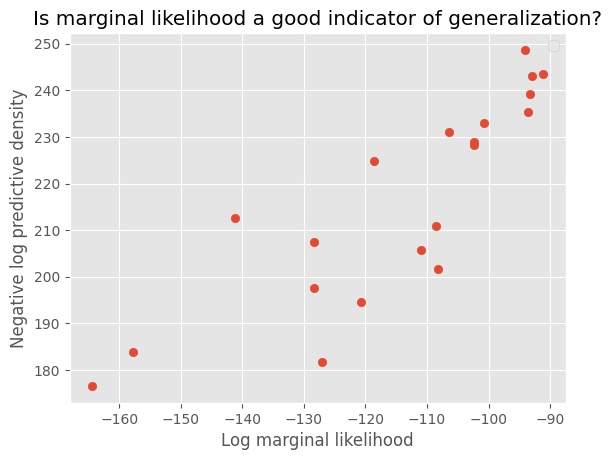

In [18]:
trials_array = np.array(clml_trials)
clml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(clml_lpd)

In [249]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

clml_function = conditional_log_marginal_likelihood(cov_func, X_con, Y_con)
aaa=clml_function(unconstrained_hyperparams)

clmls_function = conditional_log_marginal_likelihood_sequence(cov_func, X_seq, Y_seq)
clml_vals=clmls_function(unconstrained_hyperparams)


[-135.9522107  -133.7928272  -132.70732402 -128.74401939 -121.31757044
 -120.19724961 -114.741562  ]


In [251]:
clml_vals=np.array([-135.9522107,  -133.7928272 , -132.70732402, -128.74401939, -121.31757044, -120.19724961, -114.741562  ])


Array(-116.60222087, dtype=float64)

-119.23308709219984 2.9370425452409226 1.588855982992847 2.0214845746391497


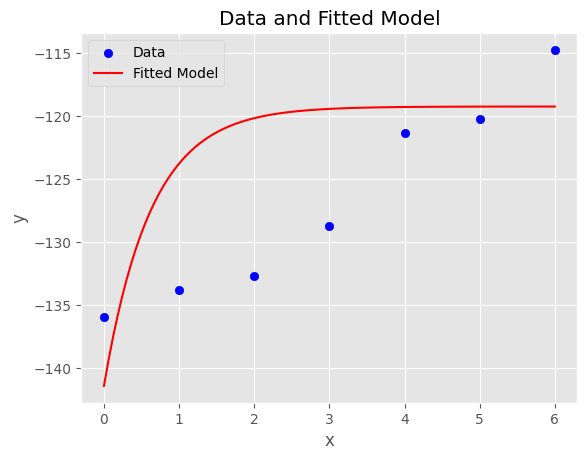

In [259]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

a,b,c,d=opt_clmls(clml_vals, T=1000, step_size=1e-4)
print(a,b,c,d)
x_data = np.arange(len(clml_vals))
y_data = np.array(clml_vals)
x_fit = np.linspace(min(x_data), max(x_data), 100)  # Smooth x range for the fitted curve
y_fit = clmls_model(x_fit, (a,b,c,d))  # Model predictions

# Plot the data
plt.scatter(x_data, y_data, color='blue', label='Data', zorder=5)

# Plot the fitted model
plt.plot(x_fit, y_fit, color='red', label='Fitted Model', zorder=4)

# Add labels, legend, and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data and Fitted Model')
plt.legend()


nan nan nan nan


In [261]:

import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')



# optimize hyperparameters according lml
clmls_trials = []

for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, clmls) = clmls_opt(cov_func, X_seq, Y_seq, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, clmls]))
   clmls_trials.append(np.array([neg_log_initial, neg_log_final, clmls]))

0
Traced<ConcreteArray([-180.80491336 -175.27221405 -171.9342892  -168.48932796 -164.94385552
 -163.2418207  -160.7122683 ], dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = Array([-180.80491336, -175.27221405, -171.9342892 , -168.48932796,
       -164.94385552, -163.2418207 , -160.7122683 ], dtype=float64)
  tangent = Traced<ShapedArray(float64[7])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[7]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x000001A9B036D1F0>, in_tracers=(Traced<ShapedArray(float64[7]):JaxprTrace(level=1/0)>,), out_tracer_refs=[<weakref at 0x000001A9B05CDDA0; to 'JaxprTracer' at 0x000001A9B05CE8E0>], out_avals=[ShapedArray(float64[7])], primitive=convert_element_type, params={'new_dtype': dtype('float64'), 'weak_type': False, 'sharding': None}, effects=frozenset(), source_info=<jax._src.source_info_util.SourceInfo object at 0x000001A9B05D6740>, ctx=JaxprEqnContext(compute_type=None, threefry_partitionable=False, xla_metadata

KeyboardInterrupt: 

In [ ]:
trials_array = np.array(clmls_trials)
clmls_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(clmls_lpd)

In [149]:
clml_function = conditional_log_marginal_likelihood_sequence(cov_func, X_seq, Y_seq)
clml_vals=clml_function(hyperparams)

[-139.76797179    3.7072365     0.36232671    0.26977747]


In [111]:
clml_vals

[Array(-144.88906846, dtype=float64),
 Array(-142.56430816, dtype=float64),
 Array(-142.10506235, dtype=float64),
 Array(-141.66981794, dtype=float64),
 Array(-141.33357905, dtype=float64),
 Array(-140.54167117, dtype=float64),
 Array(-139.98196877, dtype=float64)]

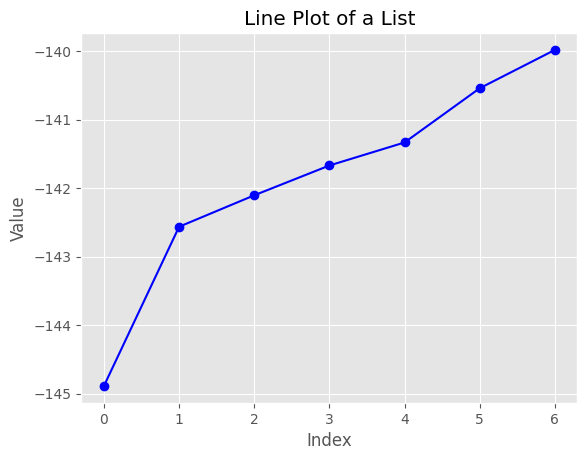

In [70]:
plt.plot(seq, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot of a List')

# Show the plot
plt.show()